## Load OpenMeteo Daily Data

In [1]:
import requests
import pandas as pd

locations = {
    'Metzingen' : {'lat':52.67057, 'long':10.37136},
    'Hannover Station 2014':  {'lat':52.4644, 'long':9.6779}
    }

dates = {
      'StartDate': '2022-01-01',
      'EndDate': '2024-11-11'
    }

loc = 'Metzingen'

openmeteo = f'https://archive-api.open-meteo.com/v1/archive?latitude={locations[loc]["lat"]}&longitude={locations[loc]["long"]}&start_date={dates["StartDate"]}&end_date={dates["EndDate"]}&daily=sunshine_duration,rain_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant&timezone=GMT'

res = requests.get(openmeteo)
if res.status_code == 200:
  data = res.json()



for k in data['daily_units']:
  print(k,data['daily_units'][k])


df = pd.DataFrame(data['daily'], columns= data['daily_units'])

df.head()


time iso8601
sunshine_duration s
rain_sum mm
wind_speed_10m_max km/h
wind_gusts_10m_max km/h
wind_direction_10m_dominant °


,time,sunshine_duration,rain_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
0,2022-01-01,0.00,0.5,22.1,42.5,241
1,2022-01-02,5070.98,2.5,28.7,56.2,232
2,2022-01-03,15384.78,7.4,33.0,69.8,249
3,2022-01-04,0.00,4.0,17.6,35.6,245
4,2022-01-05,3574.57,1.2,30.2,65.2,254


## DWD - OpenMeteo comparison moved

* new [notebook](./compare_DWD_OpenMeteo.ipynb)

## Get DHV XC flight data

* Metzingen
* Lüdingen
* Leese, Estorf (GC Landesbergen)

In [2]:
import requests
import urllib
import pandas as pd

PAGE_SIZE = 500

places = {
    'Metzingen':11185,
    'Rammelsberg': 9427,
    'Estorf': 11001,
    'Leese': 10746,
    'Porta': 9712,
    'Lüdingen':9759,
    'Brunsberg': 9844,
    'Kella': 9521,
    'Börry': 9403
}

results = []
for place in ['Metzingen','Estorf','Leese','Lüdingen']:
#for place in ['Metzingen']:
    limit = PAGE_SIZE
    for start in [0,PAGE_SIZE]:
        query = {"navpars":{"start":start,"limit":limit,"sort":[{"field":"FlightDate","dir":-1},{"field":"BestTaskPoints","dir":-1}]}}
        # for some reason, " is replaced by ' and spaces are added which is replaced by +
        decoded_url = f"https://de.dhv-xc.de/api/fli/flights?s?fkcat%5B%5D=1&fkto%5B%5D={places[place]}&{urllib.parse.urlencode(query,quote_via=urllib.parse.quote_plus).replace('%27', '%22').replace('+', '')}"
        #print(decoded_url)
        r = requests.get(decoded_url)
        if r.status_code==200:
            response = r.json()
            df0 = pd.DataFrame(response['data'])
            #print(df.columns.values)
            results.extend(df0[['FlightDate', 'TakeoffWaypointName' , 'Glider' ,'FlightDuration','UtcOffset', 'FlightStartTime']].values)


df_results = pd.DataFrame(results,columns=['FlightDate','Takeoff', 'Glider' ,'Duration','UtcOffset', 'FlightStartTime'])
print(len(df_results))
df_results.tail()

4000


,FlightDate,Takeoff,Glider,Duration,UtcOffset,FlightStartTime
3995,2021-04-20,Lüdingen,Arriba 3 S,513,2,2021-04-20 16:43:38
3996,2021-04-20,Lüdingen,MiuraRS - ML [LTF A],516,2,2021-04-20 20:02:08
3997,2021-04-20,Lüdingen,BuzzZ5,576,2,2021-04-20 13:36:34
3998,2021-04-20,Lüdingen,MiuraRS - ML [LTF A],477,2,2021-04-20 15:39:31
3999,2021-04-20,Lüdingen,Alpha 6,533,2,2021-04-20 15:50:03


## Merge weather and flight data for training and testing

* Weather data : OpenMeteo daily @ Hannover
* Flight data: Sundays and Saturdays, all 4 locations

* Training data < 2024
* Test data >= 2024

In [3]:
import numpy as np
from datetime import datetime
print(loc, locations[loc])
df['Weekday'] = df.apply(lambda row:datetime.strftime(datetime.strptime(row['time'],'%Y-%m-%d'),'%a'), axis=1)
df['alignment'] =  df.apply(lambda row: np.cos(row['wind_direction_10m_dominant']*np.pi/180.)**2,axis=1)
df = df[df['Weekday'].isin(['Sat','Sun'])]
#print(df.head())

dhv_aggr = df_results[df_results['FlightDate'] >= '2022-01-01'].groupby('FlightDate')['Duration'].count().reset_index()
dhv_aggr['Weekday'] = dhv_aggr.apply(lambda row:  datetime.strftime(datetime.strptime(row['FlightDate'],'%Y-%m-%d'),'%a'), axis=1)
dhv_aggr.rename(columns={'FlightDate':'time'},inplace=True)
#dhv_aggr.head()

dfm = df.merge(dhv_aggr, on='time', how='left')
dfm.rename(columns={'sunshine_duration':'sun','rain_sum':'rain','wind_speed_10m_max':'wind','wind_gusts_10m_max':'gust','wind_direction_10m_dominant':'dir','Duration':'flights'},inplace=True)
dfm = dfm.drop(['Weekday_y'] ,axis=1).fillna(0)

Metzingen {'lat': 52.67057, 'long': 10.37136}


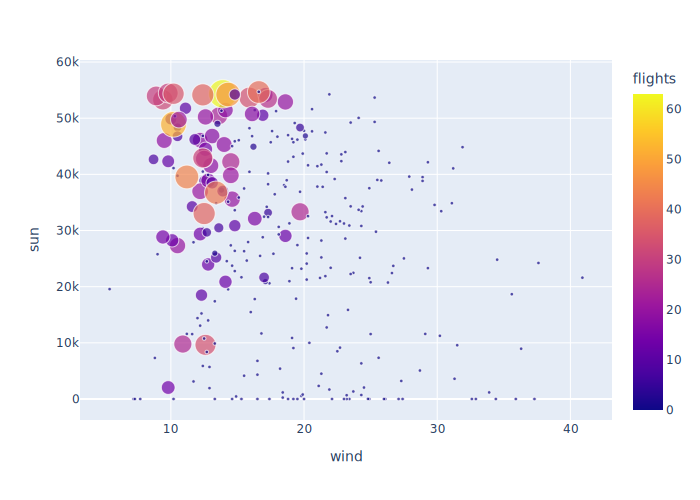

In [4]:
import plotly.express as px 
dfm['size']= dfm.apply(lambda row: row['flights']+1, axis=1)
fig = px.scatter(dfm, x='wind', y='sun', hover_data=['gust','rain','dir','sun','time'], size='size', color='flights')

fig.show('svg')


## Train model

* RandomForestRegressor with 200 estimators (decision trees)

In [5]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
import numpy as np

features = ['wind','gust','rain','sun']

test_filter =(dfm['time'] >= '2024-01-01')
train_filter = (dfm['time'] < '2024-01-01') & (dfm['time'] >= '2023-01-01')
xtrain = dfm[train_filter][features].to_numpy()
ytrain = dfm[train_filter]['flights'].to_numpy()

print(np.shape(xtrain),np.shape(ytrain))

# TODO include threshold value to be optimized
regr = RandomForestRegressor(random_state=0,n_estimators=200,max_depth=3,max_features=0.5)
regr.fit(xtrain,ytrain)


dfm['predict'] = dfm[test_filter | train_filter].apply(lambda row: regr.predict([row[features].to_numpy()])[0], axis=1)

(105, 4) (105,)


## Evaluate

* Choose some threshold to define categories
* Calculate  measures

In [6]:
thr = 4.

tp = dfm[test_filter & (dfm['flights'] > 0) & (dfm['predict'] >= thr)]
tn = len(dfm[test_filter & ~(dfm['flights'] > 0) & ~(dfm['predict'] >= thr)])
fp = dfm[test_filter & ~(dfm['flights'] > 0) & (dfm['predict'] >= thr)]
fn = dfm[test_filter & (dfm['flights'] > 0) & ~(dfm['predict'] >= thr)]

print('true pos', len(tp))
print('true neg', tn)
print('false pos', len(fp))
print('false neg', len(fn))

print('precision:', len(tp)/(len(tp)+len(fp)), 'recall:', len(tp)/(len(tp)+len(fn)) )
#print("true positives","\n", tp.to_markdown())
print("\nfalse negatives\n\n", fn.to_markdown())
print("\nfalse positives\n\n",fp.to_markdown())

true pos 20
true neg 59
false pos 7
false neg 4
precision: 0.7407407407407407 recall: 0.8333333333333334

false negatives

 |     | time       |     sun |   rain |   wind |   gust |   dir | Weekday_x   |   alignment |   flights |   size |   predict |
|----:|:-----------|--------:|-------:|-------:|-------:|------:|:------------|------------:|----------:|-------:|----------:|
| 235 | 2024-03-31 | 20871.8 |    2.5 |   14.1 |   25.9 |    19 | Sun         |  0.894005   |        13 |     14 |  3.12284  |
| 241 | 2024-04-21 | 46848.1 |    0.2 |   20.1 |   42.8 |    52 | Sun         |  0.379039   |         2 |      3 |  0.756471 |
| 279 | 2024-09-01 | 44924   |    0   |   16.2 |   36.4 |    84 | Sun         |  0.0109262  |         3 |      4 |  3.92203  |
| 284 | 2024-09-21 | 39830.4 |    0   |   14.5 |   32.8 |    90 | Sat         |  3.7494e-33 |        21 |     22 |  3.55421  |

false positives

 |     | time       |     sun |   rain |   wind |   gust |   dir | Weekday_x   |   alignment |  

## Next steps:

* generate born-again decision tree from the trained random forest
* visualize/use this data

## Ensemble characteristics

In [7]:
import numpy as np 
np.set_printoptions(precision=4, suppress=True)
 
print(features)
#print(regr.feature_names_in_)
print(regr.feature_importances_)

feature_space = {f:set() for f in features }
for rt in regr.estimators_[:200]:
    #https://scikit-learn.org/dev/auto_examples/tree/plot_unveil_tree_structure.html#sphx-glr-auto-examples-tree-plot-unveil-tree-structure-py
    #print(rt)
    tree = rt.tree_
    #print(f"tree node count: {tree.node_count}")
    for i in range(tree.node_count):
        if tree.children_left[i]!=tree.children_right[i]:
            #print(tree.feature[i], tree.threshold[i])
            feature_space[features[tree.feature[i]]].add(tree.threshold[i])
        #else:
        #    print('leaf node')

for f in feature_space:
    print(f, len(feature_space[f]),min(feature_space[f]),max(feature_space[f]))

# heuristic algo from https://arxiv.org/pdf/2003.11132 ?
# "low" lowest corner and "up" upper corner
XL, XU =  dfm[test_filter | train_filter][features].aggregate(['min','max']).to_numpy()
print(f'L: {regr.predict([XL])[0] >= thr} @ {XL}\nR: {regr.predict([XU])[0] >= thr} @ {XU}')
#XM = 0.5*(XL+XU)
#print(f'M: {regr.predict([XM])[0] >= thr} @ {XM}') # False



['wind', 'gust', 'rain', 'sun']
[0.2071 0.2267 0.0374 0.5289]
wind 77 8.799999713897705 21.299999237060547
gust 73 16.949999809265137 46.79999923706055
rain 29 0.05000000074505806 4.14999994635582
sun 106 17540.990234375 54677.3046875
L: True @ [ 7.7 14.4  0.   0. ]
R: True @ [   36.3     70.9     20.2  54699.62]
